# **Dataset**

In [1]:
!pip install py7zr -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.4/66.4 kB 3.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 41.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 399.3/399.3 kB 32.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 138.8/138.8 kB 13.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.8/49.8 kB 4.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.7/2.7 MB 96.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 93.1/93.1 kB 9.4 MB/s eta 0:00:00


In [2]:
import pandas as pd
import numpy as np
from urllib.request import urlretrieve
import requests, zipfile, io, os
import py7zr
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
from sklearn.cluster import KMeans

dataset = "https://archive.ics.uci.edu/static/public/555/apartment+for+rent+classified.zip"

r = requests.get(dataset)
z = zipfile.ZipFile(io.BytesIO(r.content))
z.extractall("/rent")

In [3]:
print(os.listdir('/rent'))
with py7zr.SevenZipFile('/rent/apartments_for_rent_classified_10K.7z', mode='r') as z:
    z.extractall(path='/rent')

['apartments_for_rent_classified_10K.7z', 'apartments_for_rent_classified_100K.7z']


In [15]:
df = pd.read_csv('/rent/apartments_for_rent_classified_10K.csv',sep=";", encoding='cp1252')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 22 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             10000 non-null  int64  
 1   category       10000 non-null  object 
 2   title          10000 non-null  object 
 3   body           10000 non-null  object 
 4   amenities      6451 non-null   object 
 5   bathrooms      9966 non-null   float64
 6   bedrooms       9993 non-null   float64
 7   currency       10000 non-null  object 
 8   fee            10000 non-null  object 
 9   has_photo      10000 non-null  object 
 10  pets_allowed   8252 non-null   object 
 11  price          10000 non-null  int64  
 12  price_display  10000 non-null  object 
 13  price_type     10000 non-null  object 
 14  square_feet    10000 non-null  int64  
 15  address        6673 non-null   object 
 16  cityname       9923 non-null   object 
 17  state          9923 non-null   object 
 18  latitud

#   **EDA**

In [162]:
df.describe()
df.shape
print(df.columns.tolist())
df.dtypes

['id', 'category', 'title', 'body', 'amenities', 'bathrooms', 'bedrooms', 'currency', 'fee', 'has_photo', 'pets_allowed', 'price', 'price_display', 'price_type', 'square_feet', 'address', 'cityname', 'state', 'latitude', 'longitude', 'source', 'time']


In [ ]:
numerical_columns = df.select_dtypes(include=['float', 'int'])
summary_statistics = numerical_columns.describe()
print("Summary Statistics:\n", summary_statistics)

categorical_columns = df.select_dtypes(include=['object'])
for column in categorical_columns:
    if column != 'body' and column != 'title':
      unique_categories = df[column].unique()
      category_frequencies = df[column].value_counts()
      print(f"\nUnique Categories in {column}:")
      print(unique_categories)
      print(f"\nCategory Frequencies in {column}:")
      print(category_frequencies)

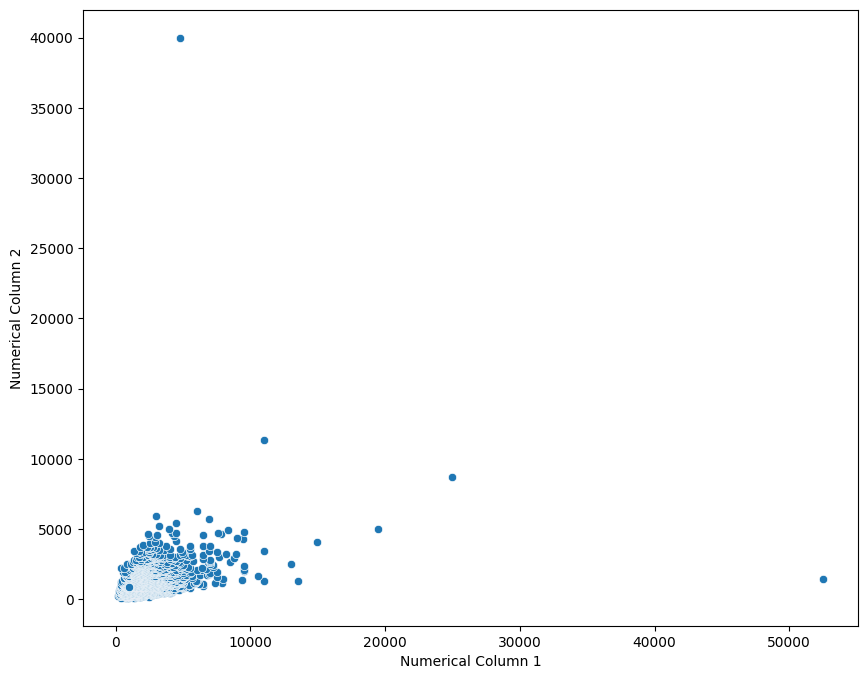

In [12]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming `df` is your DataFrame
# df = df.drop(['title', 'body', 'address', 'fee', 'currency', 'category'], axis=1)

# Distribution of numerical variables
numerical_columns = df.select_dtypes(include=['float', 'int'])
numerical_columns.hist(bins=10, figsize=(10, 8))
plt.tight_layout()
plt.show()

# Frequency distribution of categorical variables
categorical_columns = df.select_dtypes(include=['object'])
for column in categorical_columns:
    plt.figure(figsize=(10, 6))
    category_counts = df[column].value_counts()
    sns.barplot(x=category_counts.index, y=category_counts.values)
    plt.xlabel(column) # Need to fix the categories
    plt.ylabel('Frequency')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

# Relationship between variables using scatter plot
plt.figure(figsize=(10, 8))
sns.scatterplot(x='price', y='square_feet', data=df)
plt.xlabel('Numerical Column 1')
plt.ylabel('Numerical Column 2')
plt.show()

# Heatmap of correlation matrix
plt.figure(figsize=(10, 8))
correlation_matrix = df.corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.show()


# **2d: Format Dataset**

In [14]:
from sklearn.preprocessing import OneHotEncoder

def transform_to_numerical_columns(df, columns):
  df_to_encode = df[columns]
  one_hot_encoder = OneHotEncoder(sparse=False, handle_unknown='ignore')
  encoded_data = one_hot_encoder.fit_transform(df_to_encode)
  encoded_columns = one_hot_encoder.get_feature_names_out(columns)
  # Create a new DataFrame with the encoded data
  df_encoded = pd.DataFrame(encoded_data, columns=encoded_columns)
  # Concatenate the encoded DataFrame with the original DataFrame (excluding the columns to encode)
  df_final = pd.concat([df.drop(columns=columns), df_encoded], axis=1)
  return df_final

def unique_values_in_column(df, column):
  unique_values = df[column].value_counts()
  print(unique_values)

def transform_column_mapping(df, columns_mapping):
  for column, mapping in columns_mapping.items():
    df[column] = df[column].replace(mapping)
    unique_values_in_column(df, column)
  return df

def find_object_columns(df):
  object_columns = df.select_dtypes(include='object')
  object_column_names = object_columns.columns.tolist()
  print(object_column_names)

def check_if_null_or_inf(df, column):
  null_values = df[column].isnull().any()
  inf_values = df[column].isin([float('inf'), float('-inf')]).any()
  print("Null values:", null_values)
  print("Infinite values:", inf_values)

from sklearn.preprocessing import StandardScaler

def standard_scaler(df):
  print(f'the dataframe is of shape{df.shape}')
  numerical_columns = df.select_dtypes(include=['int', 'float']).columns
  print(f'Number of numerical columns {len(numerical_columns.tolist())}')
  scaler = StandardScaler()
  df[numerical_columns] = scaler.fit_transform(df[numerical_columns])
  return df

def find_null_values(df):
  null_values = df.isnull()
  total_null_count = null_values.sum().sum()
  print("Total null/NaN values:", total_null_count)

def find_rows_and_cols_with_null(df):
  null_rows = df[df.isnull().any(axis=1)]
  print("Rows with null/NaN values:")
  print(null_rows)

  null_columns = df.columns[df.isnull().any()]
  print("Columns with null/NaN values:")
  print(null_columns)

In [16]:
df.shape
# remove title, body and address columns because they dont help us diffrent value for each sample and removing currecy and fee columns because they are constant
# removing category as well because is is almost constant
df = df.drop(['title', 'body', 'address', 'fee', 'currency', 'category'], axis=1)
df = transform_to_numerical_columns(df, ['amenities', 'pets_allowed', 'price_type', 'cityname','state'])
df.shape
df.describe()
df.head()

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


,id,bathrooms,bedrooms,has_photo,price,price_display,square_feet,latitude,longitude,source,...,state_TN,state_TX,state_UT,state_VA,state_VT,state_WA,state_WI,state_WV,state_WY,state_nan
0,5668626895,NaN,0.0,Thumbnail,790,$790,101,38.9057,-76.9861,RentLingo,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,5664597177,NaN,1.0,Thumbnail,425,$425,106,37.9680,-87.6621,RentLingo,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,5668626833,1.0,0.0,Thumbnail,1390,"$1,390",107,38.8910,-77.0816,RentLingo,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
3,5659918074,1.0,0.0,Thumbnail,925,$925,116,47.6160,-122.3275,RentLingo,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
4,5668626759,NaN,0.0,Thumbnail,880,$880,125,38.8738,-77.1055,RentLingo,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0


In [17]:
mapping = {'Yes': 1, 'Thumbnail': 1, 'No': 0}
df = transform_column_mapping(df, {'has_photo': mapping} )

1    9816
0     184
Name: has_photo, dtype: int64


In [18]:
find_object_columns(df)
df['price_display'] = df['price_display'].str.replace(',','')
df['price_display'] = df['price_display'].str.replace('$','')
df['price_display'] = df['price_display'].str.replace('Weekly','')
df['price_display'] = df['price_display'].str.replace('Monthly |','')
df['price_display'] = df['price_display'].str.replace('Monthly|','')
df['price_display'] = df['price_display'].str.replace('|','')
df['price_display'] = df['price_display'].astype(int)
unique_values_in_column(df, 'price_display')


['price_display', 'source']
1350    86
1250    81
850     79
1100    77
1400    74
        ..
1667     1
2053     1
813      1
1228     1
4790     1
Name: price_display, Length: 1725, dtype: int64


<ipython-input-18-a2e9200194fb>:3: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  df['price_display'] = df['price_display'].str.replace('$','')
<ipython-input-18-a2e9200194fb>:5: FutureWarning: The default value of regex will change from True to False in a future version.
  df['price_display'] = df['price_display'].str.replace('Monthly |','')
<ipython-input-18-a2e9200194fb>:6: FutureWarning: The default value of regex will change from True to False in a future version.
  df['price_display'] = df['price_display'].str.replace('Monthly|','')
<ipython-input-18-a2e9200194fb>:7: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  df['price_display'] = df['price_display'].str.replace('|','

In [19]:
ground_truth = df.pop('source')
df = standard_scaler(df)
df['ground_truth'] = ground_truth
df.head()

the dataframe is of shape(10000, 3900)
Number of numerical columns 3900


<ipython-input-19-45a543a5a410>:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['ground_truth'] = ground_truth


,id,bathrooms,bedrooms,has_photo,price,price_display,square_feet,latitude,longitude,time,...,state_TX,state_UT,state_VA,state_VT,state_WA,state_WI,state_WV,state_WY,state_nan,ground_truth
0,0.644258,NaN,-1.850799,0.136912,-0.646825,-0.646825,-1.288365,0.220275,1.121018,0.656062,...,-0.458491,-0.092039,-0.144669,-0.040032,-0.233968,-0.176467,-0.017323,-0.010001,-0.088089,RentLingo
1,0.586860,NaN,-0.789574,0.136912,-0.985901,-0.985901,-1.280740,0.049647,0.443565,0.565064,...,-0.458491,-0.092039,-0.144669,-0.040032,-0.233968,-0.176467,-0.017323,-0.010001,-0.088089,RentLingo
2,0.644257,-0.618389,-1.850799,0.136912,-0.089439,-0.089439,-1.279215,0.217600,1.114958,0.656060,...,-0.458491,-0.092039,6.912343,-0.040032,-0.233968,-0.176467,-0.017323,-0.010001,-0.088089,RentLingo
3,0.520212,-0.618389,-1.850799,0.136912,-0.521413,-0.521413,-1.265489,1.805241,-1.756154,0.472214,...,-0.458491,-0.092039,-0.144669,-0.040032,4.274087,-0.176467,-0.017323,-0.010001,-0.088089,RentLingo
4,0.644256,NaN,-1.850799,0.136912,-0.563217,-0.563217,-1.251764,0.214470,1.113442,0.656058,...,-0.458491,-0.092039,6.912343,-0.040032,-0.233968,-0.176467,-0.017323,-0.010001,-0.088089,RentLingo


In [20]:
# find_null_values(df)
# find_rows_and_cols_with_null(df)
# unique_values_in_column(df, 'ground_truth')
print(df.shape)
df = df.dropna()
print(df.shape)

(10000, 3901)
(9950, 3901)


# **3a & 3b: Selecting the optimal number of clusters**

In [23]:
num_of_clusters = df['ground_truth'].unique()
len(num_of_clusters)

12